---
# Twitter Sentiment Analysis of Apple and Google Products for AT&T
---

Flatiron School Phase 4 Project

Analysis by Jun (Andrew) Choi, Peter Vuong, & Nicholas Wertz


<img src="img/AT&T_logo_2016.svg.png" alt="AT&T Logo" width="600"/>

---
# 1. Business Understanding
---
In the ever expanding smartphone market, it is essential to keep up with customer demand. AT&T is deciding on which product brands to offer customers in their physical and online shops and have hired our data science team to help. We have been tasked with investigating the sentiment that customers express online towards different product lines to help make a decision on what products should be stocked immediately. We then will use this data to create a model that can predict customers' thoughts on a product so that the client can remain up to date with the product demands of their clientele.

---
# 2. Data Understanding
---
The data set we primarily utilized for our modeling was initially gathered by [data.world from Twitter](https://data.world/crowdflower/brands-and-product-emotions). These tweets were gathered from attendees of Austin's South by Southwest Festival in 2013.

## Importing the Packages/Libraries


In [1]:
import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

Data.world was able to label what products these tweets referred to and labeled whether the emotions expressed were positive, negative, or neutral.


## Importing Dataset

In [2]:
# Initial loading and EDA of data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


We can see that the initial data set has been put into 3 different columns:
- The text contained in the tweet
- The product referred to in the tweet
- The emotion expressed in the tweet

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9070 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 212.7+ KB


However, we can already see that these columns will require a lot of cleaning. Almost all entries in the `tweet_text`  column contain special characters and only 3282 entries have a non-null value in the `emotion_in_tweet_is_directed_at` column. Also, it would be extremely difficult and computationally expensive to correctly identify each product mentioned in tweet due to the sheer number of targets.

---
# 3. Data Preprocessing and EDA
---
We decided the best way to deal with the number of products was to bin them into two categories (Apple and Google) based on the product listed. We created the function below that performed binning on the initial data, renamed the columns, categorized our target emotion data as numeric values where "Positive emotion" = 0, "Negative emotion" = 1, "No emotion toward brand or product" = 2, and "I can't tell" = 3. The function then drops this final "I can't tell" category, as it adds no value to our data analysis.

In [4]:
def df_cleaner(df):
    # Creating two lists to bin the brand/product column
    apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 
                  'Other Apple product or service', 'iPhone']
    google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']
    
    # Binning list comprehension for Apple, Google
    df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                              else val for val in df['emotion_in_tweet_is_directed_at']]

    df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                              else val for val in df['emotion_in_tweet_is_directed_at']]
    
    df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]
    
    # Renaming columns to simplify
    df2 = df.dropna(axis = 0)
    df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                       "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
    
    # Categorizing our target variables
    df2_label = pd.DataFrame(df2['emotion'].copy())
    emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                    "Positive emotion" : 0, 
                                    "No emotion toward brand or product" : 2,
                                    "I can't tell" : 3}})
    
    # Removing the "I can't tell" targets as it is not needed for our analysis
    df2['emotion'] = emotion
    df2['emotion'] = df2['emotion'].astype('int')
    df2 = df2[df2['emotion'] != 3]
    return df2

We then created a score printer function for our upcoming modeling iterations.

In [5]:
def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Need to explicitly declare the average for Multiclass
    avg = 'macro'
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred, average=avg) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred, average=avg) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred, average=avg) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred, average=avg) * 100), 2)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    Train Recall: {rscore_train}%
    ------------------------------
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    Test Recall: {rscore_test}%
    """)

Once we were happy with our data cleaning function, we needed to preprocess all text so that natural language processing could be properly be performed. The function below takes entered texts, tokenizes each word using a Regex tokenizer, stems words with a more aggressive Snowball Stemmer, while simultaneously removing any stopwords, before finally returning the text ready to be used for natural language processing.

In [6]:
def preprocess_text(text):
    additional  = ['rt','rts','retweet']
    pattern = '\s+'
    
    sw = set().union(stopwords.words('english'), additional)
    tokenizer = RegexpTokenizer(pattern, gaps = True)
    stemmer = SnowballStemmer(language = 'english')
    
    token = tokenizer.tokenize(text)
    
    final = [stemmer.stem(word) for word in token if word not in sw]
    
    return " ".join(final)

We created one final custom function that will show out cross validation scores for our final ensemble methods in terms of positive, negative, and neutral scores.

In [7]:
def ensemble_result_printer(model, X_train, y_train, X_test, y_test):
    
    scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    unique, counts = np.unique(model.predict(X_test), return_counts=True)
    result = np.column_stack((unique, counts))
    
    # Cleaning up scores to be more visually appealing
    Pos = "{:.2f}".format((result[0][1] / sum(counts)) * 100)
    Neg = "{:.2f}".format((result[1][1] / sum(counts)) * 100)
    Neut = "{:.2f}".format((result[2][1] / sum(counts)) * 100)

    print(f"""
Ensemble CV Score: {np.median(scores)}
Final Test Accuracy: {accuracy_score(y_test, model.predict(X_test))}
Final Test Precision: {precision_score(y_test, model.predict(X_test), average='macro')}
Final Test Recall: {recall_score(y_test, model.predict(X_test), average='macro')}
----------------------------------------------------
{result}
Positive : {Pos}%
Negative : {Neg}%
Neutral : {Neut}%
""")
    plot_confusion_matrix(model, X_test, y_test);

Next, we used the `df_cleaner` and `preprocess_text` functions we created above to prepare our data set for  NLP and modeling.

In [8]:
df2 = df_cleaner(df)

In [31]:
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
wspc = lambda x: " ".join(x.split())

df2['tweet_text'] = df2.tweet_text.map(remove_rt).map(rt)
df2['tweet_text'] = df2.tweet_text.str.lower()
df2['tweet_text'] = df2.tweet_text.map(wspc)
df2['tweet_text'] = df2["tweet_text"].map(lambda x : preprocess_text(x))
df2['emotion'].value_counts()

2    4636
0    2957
1     568
Name: emotion, dtype: int64

* Taking a look at our classes we see that there is a class imbalance that we will need to address going forward

In [10]:
X = df2['tweet_text']
y = df2['emotion']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
cv = CountVectorizer()
# Since we're transforming training set, we have to transform test set as well
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)


X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_train_vec

,00,000,00am,00pm,01am,02,03,08,10,100,...,zip,zite,zms,zombi,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train_vec.sum().sort_values(ascending=False).head()

sxsw     6500
link     2697
googl    1957
ipad     1930
appl     1742
dtype: int64

---
# 4. Modeling
---

## Baseline Model - Multinomial Naive Bayes Model

For our baseline model we decided to use a Naive Bayes Model because of its versatility when it comes to NLP specifically.

In [14]:
# Initialize baseline MultinomialBayes for NLP
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()


    Train Accuracy: 80.0%
    Train Precision: 79.32%
    Train Recall: 68.84%
    ------------------------------
    Test Accuracy: 64.67%
    Test Precision: 59.53%
    Test Recall: 50.23%
    


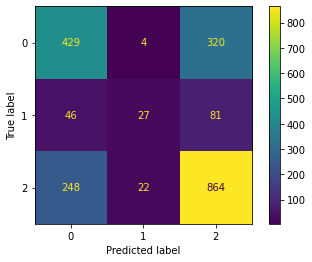

In [15]:
# Creating initial predictions
y_preds = mnb.predict(X_train_vec)
y_test_pred = mnb.predict(X_test_vec)

score_matrix_printer(mnb, X_train_vec, y_train, X_test_vec, y_test)

- We can see that our baseline has an 
- Accuracy of 65% 
- Precision of 59%
- Recall of 50%

## Model 1 -  Pipeline Model for Multinomial Bayes & SMOTE

For the next iteration we decided to oversample to deal with the class imbalance that was present in our data


    Train Accuracy: 78.38%
    Train Precision: 70.28%
    Train Recall: 75.93%
    ------------------------------
    Test Accuracy: 62.91%
    Test Precision: 54.16%
    Test Recall: 56.6%
    


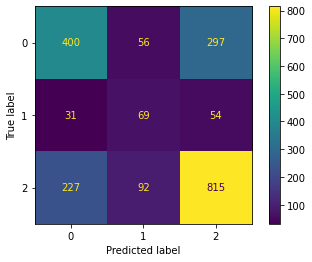

In [16]:
# Pipeline model for Multinomial Bayes + SMOTE
mnb_cv = imbpipeline(steps=[
    ('vectorizer', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_train, y_train)
score_matrix_printer(mnb_cv, X_train, y_train, X_test, y_test)

We see that after oversampling to deal with class imbalance that our accuracy and precision have dropped slightly, but the recall has improved by 6%

## Model 2 -  Pipeline Model to Test TFIDF Vectorizer

For the next model we used a Tfid Vectorizer instead of a Count vectorizer to evaluate the difference in performance


    Train Accuracy: 76.39%
    Train Precision: 69.54%
    Train Recall: 82.3%
    ------------------------------
    Test Accuracy: 59.82%
    Test Precision: 54.02%
    Test Recall: 62.14%
    


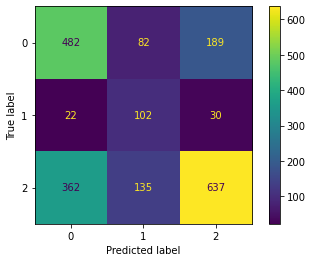

In [17]:
# Pipeline model to test if TfidfVectorizer
mnb_tfidf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf, X_train, y_train, X_test, y_test)

Once again our accuracy dropped, but our recall improved by another 6%

## Model 2.5 - TFIDF Vectorizer with `max_features` = 1500

We then decided to quickly check if declaring the max_features in our vectorizer would improve model performance


    Train Accuracy: 68.27%
    Train Precision: 61.44%
    Train Recall: 74.25%
    ------------------------------
    Test Accuracy: 57.52%
    Test Precision: 51.46%
    Test Recall: 58.64%
    


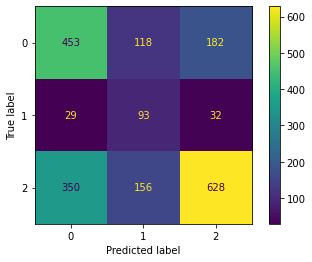

In [18]:
mnb_tfidf_mf = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('SMOTE', SMOTE(random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf_mf.fit(X_train, y_train)
score_matrix_printer(mnb_tfidf_mf, X_train, y_train, X_test, y_test)

We see that the max features of 1500 we declared actually reduced our model's over performance for the Naive Bayes model

## Model 3 -  Random Forest Classifier


    Train Accuracy: 95.85%
    Train Precision: 95.8%
    Train Recall: 95.82%
    ------------------------------
    Test Accuracy: 65.95%
    Test Precision: 65.88%
    Test Recall: 53.51%
    


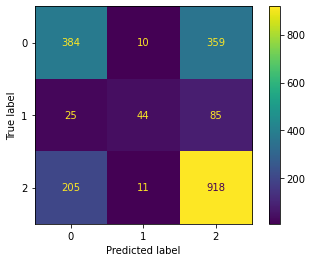

In [34]:
rf_model_max = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(random_state = 42))

])

rf_model_max.fit(X_train, y_train)
score_matrix_printer(rf_model_max, X_train, y_train, X_test, y_test)

Here we see a significant improvement accross the board in all our scores except the recall. However, we can clearly see that our model is severly overfit which makes sense as we did not declare any stopping parameters for our RandomForestClassifier

## Using `GridSerachCV` to Optimize Model Parameters

We then decided to deploy an optimizer for our RandomForestClassifier using a GridSearch

In [36]:
# #Code block has been commented out as it takes over 10 minutes to run.

# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, random_state=42)

# rf_basic_cv = imbpipeline(steps=[
#     ('preprocess', TfidfVectorizer(lowercase = False)),
#     ('SMOTE', SMOTE(random_state = 42)),
#     ('rf', RandomForestClassifier(random_state=42))
# ])


# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            


# grid = GridSearchCV(rf_basic_cv, param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid.fit(X_train_grid, y_train_grid)   

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TfidfVectorizer(lowercase=False)),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [1, 10, 25, 50],
                         'rf__min_samples_leaf': range(1, 10),
                         'rf__min_samples_split': range(1, 10),
                         'rf__n_estimators': [30, 100, 150, 200]},
             verbose=1)

In [37]:
# print('Best score and parameter combination = ')

# print(grid.best_score_)    
# print(grid.best_params_)      

Best score and parameter combination = 
0.6490196078431373
{'rf__criterion': 'gini', 'rf__max_depth': 50, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 100}


From the `GridSearchCV` above, we determined the optimal parameters for `TfidfVectorizer` and `RandomForestClassifier`. We tested these optimized parameters in the next model.


## Model 4 - Random Forest Classifier with Optimized Parameters


    Train Accuracy: 89.89%
    Train Precision: 91.51%
    Train Recall: 87.02%
    ------------------------------
    Test Accuracy: 64.48%
    Test Precision: 62.54%
    Test Recall: 51.94%
    


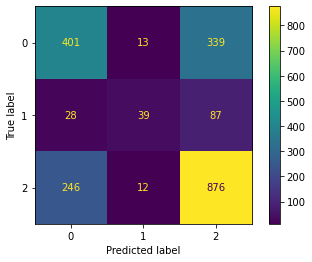

In [38]:
rf_optimal_cv = imbpipeline(steps=[
    ('vectorizer', TfidfVectorizer(lowercase = False)),
    ('smote', SMOTE(random_state = 42)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators = 100,  max_depth = 50, 
                                  min_samples_leaf = 1, min_samples_split = 8, random_state = 42))

])

rf_optimal_cv.fit(X_train, y_train)
score_matrix_printer(rf_optimal_cv, X_train, y_train, X_test, y_test)

- After running our RandomForestClassifier with the optimal parameters from our GridSearch we end up with slightly lower scores in comparison to our previous model.
- However, we are no longer overfitting which is a necessary trade off

## Model 5 - Ensemble Model Using All Data 

Finally we decided to combine our Naive Bayes and Random Forest models to see if we can further improve model performance


Ensemble CV Score: 0.6454248366013072
Final Test Accuracy: 0.6447819696227339
Final Test Precision: 0.625420044660636
Final Test Recall: 0.5194233487726184
----------------------------------------------------
[[   0  675]
 [   1   64]
 [   2 1302]]
Positive : 33.07%
Negative : 3.14%
Neutral : 63.79%



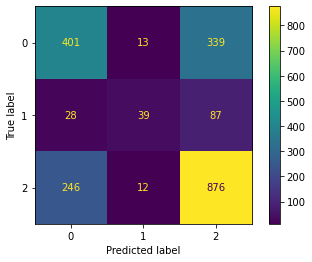

In [43]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf)],
                                    weights = [0.75, 0.25])

avg.fit(X_train, y_train)

ensemble_result_printer(avg, X_train, y_train, X_test, y_test)

From these results we decided to split the data into two different sets based on the company that produced the products being mentioned to see how well our ensemble would perform on them.

In [25]:
apple = df2.loc[df2['product'] == 'Apple']
google = df2.loc[df2['product'] == 'Google']

a_X = apple['tweet_text']
a_y = apple['emotion']

g_X = google['tweet_text']
g_y = google['emotion']

In [26]:
a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(a_X, a_y, random_state=42)

g_X_train, g_X_test, g_y_train, g_y_test = train_test_split(g_X, g_y, random_state=42)

## Ensemble Model - Apple Data 


Ensemble CV Score: 0.6162642947903431
Final Test Accuracy: 0.631859756097561
Final Test Precision: 0.6259147526521057
Final Test Recall: 0.5386813520834399
----------------------------------------------------
[[  0 515]
 [  1  56]
 [  2 741]]
Positive : 39.25%
Negative : 4.27%
Neutral : 56.48%



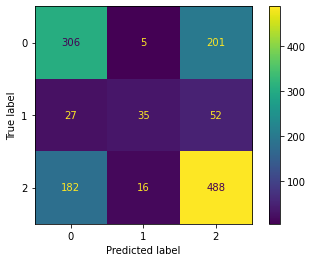

In [46]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf)],
                                    weights = [0.75, 0.25])

avg.fit(a_X_train, a_y_train)

ensemble_result_printer(avg, a_X_train, a_y_train, a_X_test, a_y_test)

## Ensemble Model - Google Data 


Ensemble CV Score: 0.7185354691075515
Final Test Accuracy: 0.6831275720164609
Final Test Precision: 0.6034739522952073
Final Test Recall: 0.4799549197415051
----------------------------------------------------
[[  0 142]
 [  1  16]
 [  2 571]]
Positive : 19.48%
Negative : 2.19%
Neutral : 78.33%



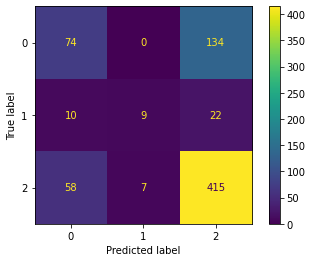

In [47]:
avg = VotingClassifier(estimators=[ ('rf', rf_optimal_cv),
                                    ('mb', mnb_tfidf)],
                                    weights = [0.75, 0.25])

avg.fit(g_X_train, g_y_train)

ensemble_result_printer(avg, g_X_train, g_y_train, g_X_test, g_y_test)

---
# 5. Evaluation
---

Here we found that the sentiment breakdown for Apple was:
- Positive : 39.25%
- Negative : 4.27%
- Neutral : 56.48% <br>
With 63% Accuracy and 63% Precision <br>
<br>
While Google was: 
- Positive : 19.48%
- Negative : 2.19%
- Neutral : 78.33% <br>
With 68% Accuracy and 60% Precision

This means that people have shown a more positive reaction to apple products in comparison to Google. <br>
While Google actually has a majority of neutral sentiment meaning that most people do not care either way.
From this we concluded that having both Apple and Google products would be beneficial. <br>
However, placing more weight/emphasis on restocking Apple products may be more beneficial as there is more buzz on twitter in regards to apple products which could increase profits as well as overall traffic to AT&T by simply have Apple products.

---
# 6. Appendix
---

The below code was used to create a wordcloud for our presentation.

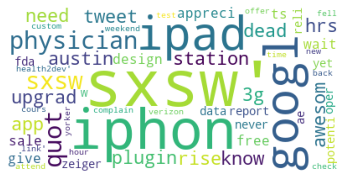

In [29]:
from wordcloud import WordCloud

text = X.values 

wordcloud = WordCloud(background_color = 'white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [30]:
# wordcloud.to_file("img/apple_google_wordcloud.png")  #Saves the wordcloud image as a .png file